In [4]:
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# read data
df = pd.read_csv('../data/euroleaks/cleaned.csv')

# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

trigram_colloc = {('euro', 'working', 'group')}

bigram_colloc = {
    ('20th', 'february'),
    ('aide', 'memoire'),
    ('anti', 'corruption'),
    ('brussel', 'group'),
    ('capital', 'control'),
    ('central', 'bank'),
    ('collective', 'bargaining'),
    ('common', 'ground'),
    ('debt', 'sustainability'),
    ('govern', 'council'),
    ('growth', 'friendly'),
    ('interest', 'rate'),
    ('labor', 'market'),
    ('maximum', 'flexibility'),
    ('member', 'state'),
    ('minimum', 'wage'),
    ('primary', 'surplus'),
    ('prime', 'minister'),
    ('prior', 'action'),
    ('product', 'market'),
    ('second', 'letter'),
    ('smp', 'bond'),
    ('structural', 'reform'),
    ('successful', 'conclusion'),
    ('technical', 'team'),
    ('real', 'estate')
}

### preprocessing

In [6]:
import spacy

nlp = spacy.load('en_core_web_sm')  # speed
#nlp = spacy.load('en_core_web_trf') # accuracy, but very slow

In [7]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.is_stop\
        and not token.text in stopwords['names']\
        and not token.text in stopwords['artifacts']\
        and len(token.text) > 1

# and not token.text in stopwords['weak_speaker_discriminants_0.1']\

#### document = date

In [8]:
grouped = df.drop(columns=['timestamp','speaker']).groupby('date').apply(lambda s: ' '.join(s.speech))

In [9]:
dates = grouped.index.to_series().apply(lambda label: pd.to_datetime(label).strftime('%d/%m')).values

In [10]:
t = time.time()

documents = [
    [token.lemma_ for sentence in nlp(doc).sents for token in sentence
            if filter_token(token)
    ]
    for doc in grouped.values 
]

# apply collocations
documents = [
    apply_bigram_colloc(apply_trigram_colloc(' '.join(doc), trigram_colloc), bigram_colloc).split()
    for doc in documents]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.77 mins


In [11]:
documents[0][:5]

['response', 'question', 'ask', 'commission', 'headline']

**documents** is a list of lists of words.

### gensim LDA topic model

In [12]:
from gensim.models import LdaMulticore , TfidfModel
from gensim.corpora import Dictionary
import multiprocessing

In [13]:
dictionary = Dictionary(documents)

dictionary.filter_extremes(
    no_below=2,  # Keep tokens which are contained in at least no_below documents.
    no_above=.5 # Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
)

In [14]:
ldacorpus = [dictionary.doc2bow(text) for text in documents]

tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus]

In [15]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(ldacorpus))

Number of unique tokens: 1330
Number of documents: 12


In [18]:
# train the model
t = time.time()

num_passes = 50
num_topics = 4
# find chunksize to make about 200 updates
#chunk_size = len(model_corpus) * num_passes/200
chunk_size = 2000

model = LdaMulticore(model_corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     workers=min(10, multiprocessing.cpu_count()-1),
                     passes=num_passes,
                     chunksize=chunk_size)

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.29 mins


In [19]:
# get topic proportions
topic_corpus = model[model_corpus]

In [20]:
topic_corpus[2]

[(0, 0.013942054), (1, 0.01402661), (2, 0.95761466), (3, 0.0144166965)]

In [21]:
# examine the learned topics
model.print_topics()

[(0,
  '0.003*"referendum" + 0.002*"credibility" + 0.001*"growth_friendly" + 0.001*"prior_action" + 0.001*"adjourn" + 0.001*"vote" + 0.001*"summit" + 0.001*"principle" + 0.001*"combination" + 0.001*"night"'),
 (1,
  '0.003*"second_letter" + 0.002*"aide_memoire" + 0.002*"letter" + 0.002*"prior_action" + 0.002*"growth_friendly" + 0.001*"strategic" + 0.001*"saturday" + 0.001*"referendum" + 0.001*"sell" + 0.001*"smart"'),
 (2,
  '0.002*"referendum" + 0.002*"letter" + 0.002*"successful_conclusion" + 0.002*"elstat" + 0.001*"installment" + 0.001*"brussel_group" + 0.001*"april" + 0.001*"valid" + 0.001*"starting" + 0.001*"sufficiently"'),
 (3,
  '0.003*"interest_rate" + 0.002*"bill" + 0.001*"accelerate" + 0.001*"side" + 0.001*"brussel_group" + 0.001*"concession" + 0.001*"april" + 0.001*"13th" + 0.001*"overall" + 0.001*"live"')]

In [22]:
# pretty print
import re
topic_sep = re.compile(r"0\.[0 -9]{3}\*")

model_topics = [( topic_no , re.sub(topic_sep , '', model_topic).
    split(' + ')) for topic_no , model_topic in
        model.print_topics(num_topics=num_topics,
    num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "referendum", "credibility", "growth_friendly", "prior_action", "adjourn"
2 "second_letter", "aide_memoire", "letter", "prior_action", "growth_friendly"
3 "referendum", "letter", "successful_conclusion", "elstat", "installment"
4 "interest_rate", "bill", "accelerate", "side", "brussel_group"


In [23]:
from collections import defaultdict

topic_proportions = pd.DataFrame(np.zeros((len(topic_corpus), num_topics)))

for i,doc in enumerate(topic_corpus):
    for topic in doc:
        topic_proportions.iloc[i,topic[0]] = topic[1]
    
#pd.DataFrame(topic_proportions, index=dates)
topic_proportions.set_index(dates, inplace=True)

topic_proportions

,0,1,2,3
24/02,0.018857,0.018942,0.943073,0.019128
17/03,0.021223,0.021271,0.021493,0.936013
01/04,0.013942,0.014027,0.957639,0.014392
24/04,0.012962,0.013015,0.013071,0.960951
11/05,0.014709,0.014782,0.014907,0.955601
18/06,0.021176,0.021635,0.021328,0.935861
22/06,0.015137,0.954400,0.015138,0.015325
24/06,0.942600,0.019325,0.019022,0.019052
25/06,0.015537,0.953358,0.015489,0.015616
27/06,0.941544,0.019431,0.019530,0.019495


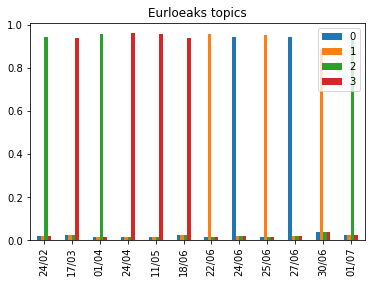

In [31]:
ax = topic_proportions.plot.bar()
_=ax.set_title('Eurloeaks topics')

In [29]:
# pretty print
import re
topic_sep = re.compile(r"0\.[0 -9]{3}\*")

model_topics = [( topic_no , re.sub(topic_sep , '', model_topic).
    split(' + ')) for topic_no , model_topic in
        model.print_topics(num_topics=num_topics,
    num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

0 "referendum", "credibility", "growth_friendly", "prior_action", "adjourn"
1 "second_letter", "aide_memoire", "letter", "prior_action", "growth_friendly"
2 "referendum", "letter", "successful_conclusion", "elstat", "installment"
3 "interest_rate", "bill", "accelerate", "side", "brussel_group"
